In [2]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant
from myplot import geo_precentage

# Load data

In [3]:
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmills = pd.read_csv(constant.windmill_path, dtype=dtype)
df = pd.read_parquet("./data/dfAgg.parquet")

In [4]:
# df = df[["VAERDI", "ws10","Aspect", "Elevation", "Roughness", "Slope"]].sample(frac=0.001, random_state=1)

In [5]:
windmills["Slope"] = round(windmills["Slope"], 0)
windmills["Aspect"] = round(windmills["Aspect"], 0)

In [6]:
windmill_SL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="W"]
windmill_SH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="W"]
windmill_PL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="P"]
windmill_PH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="P"]

# The proportion of windmills under geo information
Roughness, Slope, Aspect

In [7]:
def geo_table(geofeature):
    type_place = ["SL","SH","PL","PH"]
    rt = pd.DataFrame(np.unique(windmills[geofeature]), columns=[geofeature]) 
    geo_count = lambda df, name: df.groupby(geofeature, as_index=False)["GSRN"].count().rename({"GSRN":name}, axis=1)
    for df, n in zip([windmill_SL, windmill_SH, windmill_PL, windmill_PH], type_place):
        tmp = geo_count(df, n)
        tmp[n] = round(tmp[n] / len(df) * 100, 2)
        rt = pd.merge(tmp, rt, on=geofeature, how="right")
    rt = rt.fillna(0)
    rt = rt.sort_values([geofeature]).reset_index(drop=True)

    cols = [x for x in rt.columns if x != geofeature]
    rt = rt.T
    headers = rt.iloc[0]
    rt  = pd.DataFrame(rt.values[1:], columns=headers)
    rt["type_place"] = cols
    rt = rt.set_index("type_place")

    return rt

In [8]:
rn_count = geo_table("Roughness")
rn_count

Roughness,0.001,0.003,0.005,0.030,0.050,0.100,0.300,0.500,0.600
type_place,,,,,,,,,
PH,100.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
PL,0.87,0.00,93.01,0.87,0.0,2.18,2.18,0.44,0.44
SH,87.50,0.00,0.00,0.00,0.0,12.50,0.00,0.00,0.00
SL,0.46,0.13,93.24,0.72,0.2,1.02,2.92,0.33,0.98


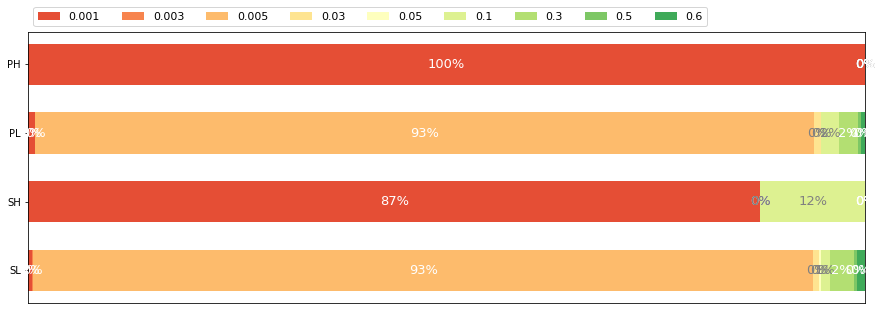

In [10]:
geo_precentage(rn_count, rn_count.columns)

In [11]:
slope_count = geo_table("Slope")
slope_count

Slope,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,15.0
type_place,,,,,,,,,,,,,,,
PH,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PL,42.79,20.09,10.48,17.03,2.62,4.37,1.75,0.00,0.44,0.44,0.00,0.00,0.00,0.00,0.00
SH,93.75,0.00,6.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SL,40.05,18.01,12.50,20.56,4.10,2.26,1.38,0.33,0.49,0.16,0.03,0.03,0.03,0.03,0.03


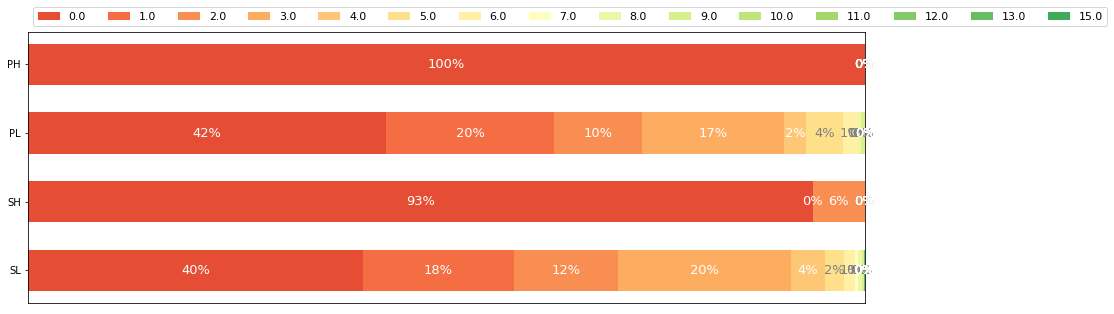

In [13]:
geo_precentage(slope_count, slope_count.columns)

In [14]:
aspect_count = geo_table("Aspect")
cols = [x for x in aspect_count.columns if x not in [-1.0, 0.0]]
aspect_count["others"] = aspect_count.apply(lambda x: sum(x[cols]), axis=1)
aspect_count

Aspect,-1.0,0.0,5.0,6.0,8.0,9.0,11.0,14.0,15.0,18.0,...,329.0,333.0,337.0,342.0,345.0,346.0,349.0,352.0,354.0,others
type_place,,,,,,,,,,,,,,,,,,,,,
PH,100.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PL,42.79,3.06,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.31,...,0.0,0.00,0.0,1.31,0.00,0.00,0.00,0.00,0.00,54.17
SH,93.75,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.0,0.00,0.0,6.25,0.00,0.00,0.00,0.00,0.00,6.25
SL,40.05,3.74,0.03,0.03,0.07,0.03,0.1,0.1,0.03,1.21,...,0.2,0.92,0.0,1.28,0.03,0.13,0.13,0.03,0.03,56.15


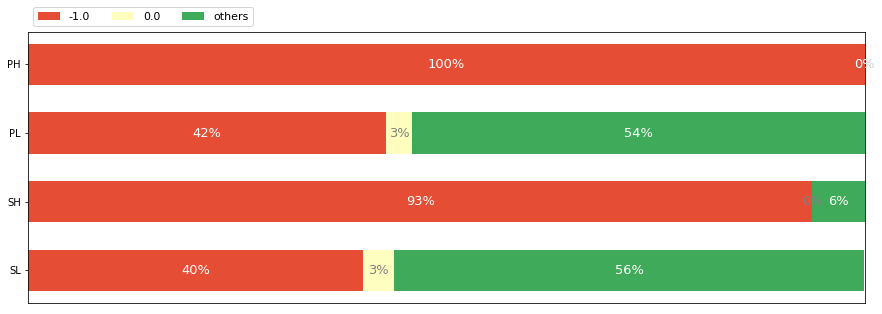

In [15]:
geo_precentage(aspect_count,[-1.0, 0.0, "others"])

# A simulation of wind speed interpolation with various roughness length

Wind Speed 10m: 6 m/s  
Roughness range: \[0.000001, 0.0003, 0.0005, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6\]  
Interpolated height range: \[0,100\] m

In [16]:
from tools import pow_law, rn_exponent

In [17]:
get_ws_h_rn = lambda h, rn : round(pow_law(ws_ass10, 10, h, rn_exponent(rn)), 5)
get_ws_h_smrn = lambda h, rn : round(pow_law(ws_ass10, 10, h, rn), 5)

In [18]:
ws_ass10 = 6
rn_range = (0.001, 0.003, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6)
h_range = np.linspace(0.1,100,201)

In [19]:
ls = pd.DataFrame([], columns=h_range, index = rn_range)

In [20]:
for rn in rn_range:
    for h in h_range:
        ls.loc[rn][h] = get_ws_h_rn(h, rn) if rn >= 0.001 else get_ws_h_smrn(h, rn)

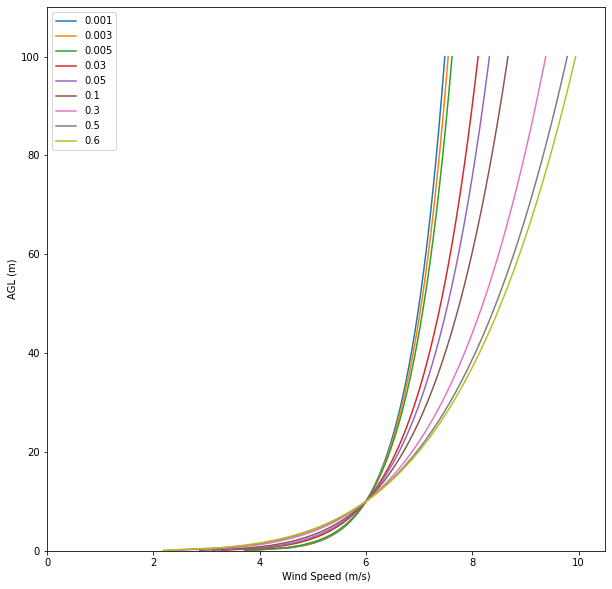

In [23]:
# from scipy.interpolate import make_interp_spline

plt.figure(figsize=(10, 10))
plt.xlim(0, 10.5)
plt.ylim(0, 110)
x_new = np.linspace(0,11,100)
for rn, ws in ls.iterrows():
    plt.plot(ws, h_range, label='{:f}'.format(rn).rstrip('0'))
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("AGL (m)")
plt.legend()
